In [91]:
import sys
print(sys.path)

['C:\\Users\\Veli Can Erdem\\Desktop\\Courses\\Bio-inspired Computer Vision\\biocv_project\\Bio_inspired_Optical_flow-master\\src', 'C:\\ProgramData\\Anaconda3\\python38.zip', 'C:\\ProgramData\\Anaconda3\\DLLs', 'C:\\ProgramData\\Anaconda3\\lib', 'C:\\ProgramData\\Anaconda3', '', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Veli Can Erdem\\.ipython']


In [92]:
import os

# import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from util import (
    Timer,
    Event,
    normalize_image,
    animate,
    load_events,
)
from time import time
from scipy import fftpack, signal

plt.close("all")

In [93]:
scale_factor = 1  # scale factor to compress in time (detect faster motions)

#mono_wm1 = 1.95
#mono_wm2 = 0.23
#mono_mium1 = 0.55 * sf
#mono_mium2 = 0.55 * sf
#mono_sigmam1 = 0.10 * sf
#mono_sigmam2 = 0.16 * sf

#bi_wm1 = 0.83
#bi_wm2 = -0.34
#bi_mium1 = 0.44 * sf
#bi_mium2 = 0.63 * sf
#bi_sigmam1 = 0.12 * sf
#bi_sigmam2 = 0.21 * sf
#x0 = 0
#y0 = 0

#bi1_mean and scale_bi's are only hyperparameters
scale_bi1 = 1/2
scale_bi2 = 3/4

bi1_mean = 0.2 * scale_factor
bi2_mean = bi1_mean * 2
mono_mean = (1 * scale_factor + bi1_mean * np.sqrt(36 + 10 * np.log(scale_bi1 / scale_bi2))) / 10
# 3 sigma rule for bi1 and mono
bi1_sigma = bi1_mean / 3
bi2_sigma = bi1_sigma * (3/2)
mono_sigma = mono_mean / 3

f0x = 0.057  # units: cycles/pix ?
#f0x = -0.1012  # related to -90 pix/sec of ground truth optical flow
#f0x = 0.08
f0y = f0x

In [94]:
# Load events

path_to_events = '../slider_far/events_chunk.txt'
event_list = pd.read_csv(path_to_events, delim_whitespace=True, header=None,
                          names=['t', 'x', 'y', 'p'],
                          dtype={'t': np.float64, 'x': np.int16, 'y': np.int16, 'p': np.int8},
                          engine='c', nrows=None, memory_map=True)
event_list = event_list.to_numpy()

# First row: time, x, y, polarity
print(event_list[0])
time_start = event_list[0][0]
time_end = event_list[len(event_list)-1][0]

print("Loaded {:.2f}M events.".format(len(event_list) / 1e6))
print("Time between: {} and {}.".format(time_start, time_end))

[3.811e-03 9.600e+01 1.330e+02 0.000e+00]
Loaded 0.05M events.
Time between: 0.003811 and 0.174156.


In [95]:
tau = math.pi * 2  # apparently there is a name for 2*pi

def spatial_gabor_filter_even(x, y, sigma, theta, f0x, f0y):
    x_hat = np.cos(theta) * x + np.sin(theta) * y
    y_hat = -np.sin(theta) * x + np.cos(theta) * y

    gabor_first = np.exp(-1 * ((x_hat - f0x)**2 + (y_hat - f0y)**2) * (2 * math.pi**2) / sigma**2)
    gabor_second = np.cos(tau * (f0x * x_hat + f0y * y_hat))
    gabor_even = (tau / sigma**2) * gabor_first * gabor_second

    return gabor_even


def spatial_gabor_filter_odd(x, y, sigma, theta, f0x, f0y):
    x_hat = np.cos(theta) * x + np.sin(theta) * y
    y_hat = -np.sin(theta) * x + np.cos(theta) * y

    gabor_first = np.exp(-1 * ((x_hat - f0x)**2 + (y_hat - f0y)**2) * (2 * math.pi**2 / sigma**2))
    gabor_second = np.sin(tau * (f0x * x_hat + f0y * y_hat))
    gabor_odd = (tau / sigma**2) * gabor_first * gabor_second

    return gabor_odd

In [96]:
def temporal_filter(t, mu, sigma):
    temp_filter = np.exp(-(t - mu)**2 / (2 * sigma**2))
    
    return temp_filter


33.333333333333336


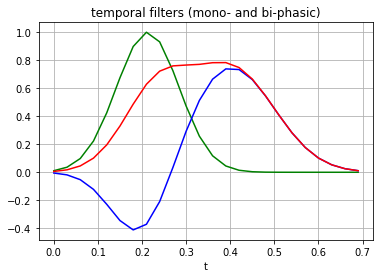

In [117]:
dt_res = 0.03 * scale_factor
ft_nyquist = 1.0 / dt_res  # Nyquist sampling frequency
print(ft_nyquist)  # Hz

t = np.arange(0.0, 0.7 * scale_factor, dt_res)
Tmono = temporal_filter(t, mono_mean, mono_sigma)
Tbi = -1 * scale_bi1 * temporal_filter(t, bi1_mean, bi1_sigma)
Tbi += scale_bi2 * temporal_filter(t, bi2_mean, bi2_sigma)

fig2, ax1 = plt.subplots()
val_max = np.max([np.max(np.abs(Tmono)), np.max(np.abs(Tbi))])
ax1.plot(t, Tmono / val_max, "g-")
ax1.plot(t, Tbi / val_max, "b-")
ax1.plot(t, (Tmono+Tbi) / val_max, "r-")
ax1.set_title("temporal filters (mono- and bi-phasic)")
ax1.set_xlabel("t")
plt.savefig("temporal_filters_mono_bi.png")
plt.grid()
plt.show()


[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


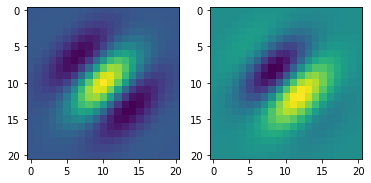

In [118]:
hksize = 10 # half of the kernel size
ksize = 2 * hksize + 1  # kernel size
x = np.linspace(-hksize, hksize, ksize)
print(x)
xv, yv = np.meshgrid(x, x)

dx = 1.0  # pixels
ft_nyquist = 1.0 / dx  # Nyquist sampling frequency in (x,y)-space, in cycles / pix
# So f0x and f0y cannot be larger than 0.5 cycles / pix

spatial_sigma = 25
f0x = 0.057
f0y = f0x

G_even = spatial_gabor_filter_even(xv, yv, spatial_sigma, 0, f0x, f0y)
G_odd = spatial_gabor_filter_odd(xv, yv, spatial_sigma, 0, f0x, f0y)
fig = plt.figure()
plt.subplot(1, 2, 1), plt.imshow(G_even)
plt.subplot(1, 2, 2), plt.imshow(G_odd)
plt.savefig("filters.png")

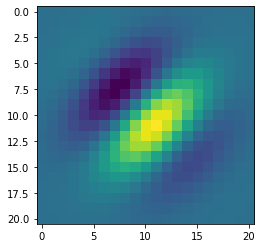

In [99]:
plt.imshow(G_even + G_odd)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2359cc7b2e0>)

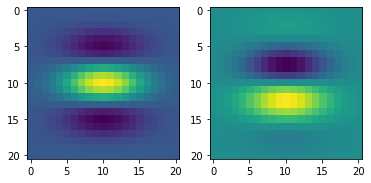

In [100]:
G_even = spatial_gabor_filter_even(xv, yv, spatial_sigma, np.pi / 4, f0x, f0y)
G_odd = spatial_gabor_filter_odd(xv, yv, spatial_sigma, np.pi / 4, f0x, f0y)
fig = plt.figure()
plt.subplot(1, 2, 1), plt.imshow(G_even)
plt.subplot(1, 2, 2), plt.imshow(G_odd)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2359cd14100>)

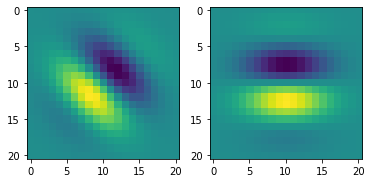

In [101]:
G_even = spatial_gabor_filter_even(xv, yv, spatial_sigma, np.pi / 2, f0x, f0y)
G_even = spatial_gabor_filter_odd(xv, yv, spatial_sigma, np.pi / 2, f0x, f0y)
fig = plt.figure()
plt.subplot(1, 2, 1), plt.imshow(G_even)
plt.subplot(1, 2, 2), plt.imshow(G_odd)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2359d2982e0>)

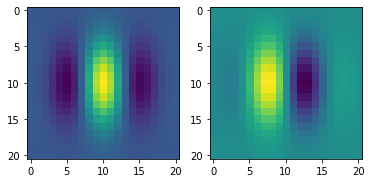

In [102]:
G_even = spatial_gabor_filter_even(xv, yv, spatial_sigma, np.pi / 4 * 3, f0x, f0y)
G_odd = spatial_gabor_filter_odd(xv, yv, spatial_sigma, np.pi / 4 * 3, f0x, f0y)
fig = plt.figure()
plt.subplot(1, 2, 1), plt.imshow(G_even)
plt.subplot(1, 2, 2), plt.imshow(G_odd)

In [103]:
space_time_kernel_1 = G_even[:, :, None] * Tbi
space_time_kernel_2 = G_odd[:, :, None] * Tmono
space_time_kernel_full = space_time_kernel_1 + space_time_kernel_2

np.save("space_time_kernel1.npy", space_time_kernel_1)
np.save("space_time_kernel2.npy", space_time_kernel_2)
np.save("space_time_kernel_combined.npy", space_time_kernel_full)

In [104]:
# Filter bank
angle = np.arange(0.0, np.pi, np.pi / 8)
print(angle)
num_orientations = len(angle)

filters = []
for an in angle:
    G_even = spatial_gabor_filter_even(xv, yv, spatial_sigma, an, f0x, 0.0)
    G_odd = spatial_gabor_filter_odd(xv, yv, spatial_sigma, an, f0x, 0.0)
    space_time_kernel = G_even[:, :, None] * Tbi + G_odd[:, :, None] * Tmono
    filters.append(space_time_kernel)

# size of each kernel
space_time_kernel.shape

[0.         0.39269908 0.78539816 1.17809725 1.57079633 1.96349541
 2.35619449 2.74889357]


(21, 21, 24)

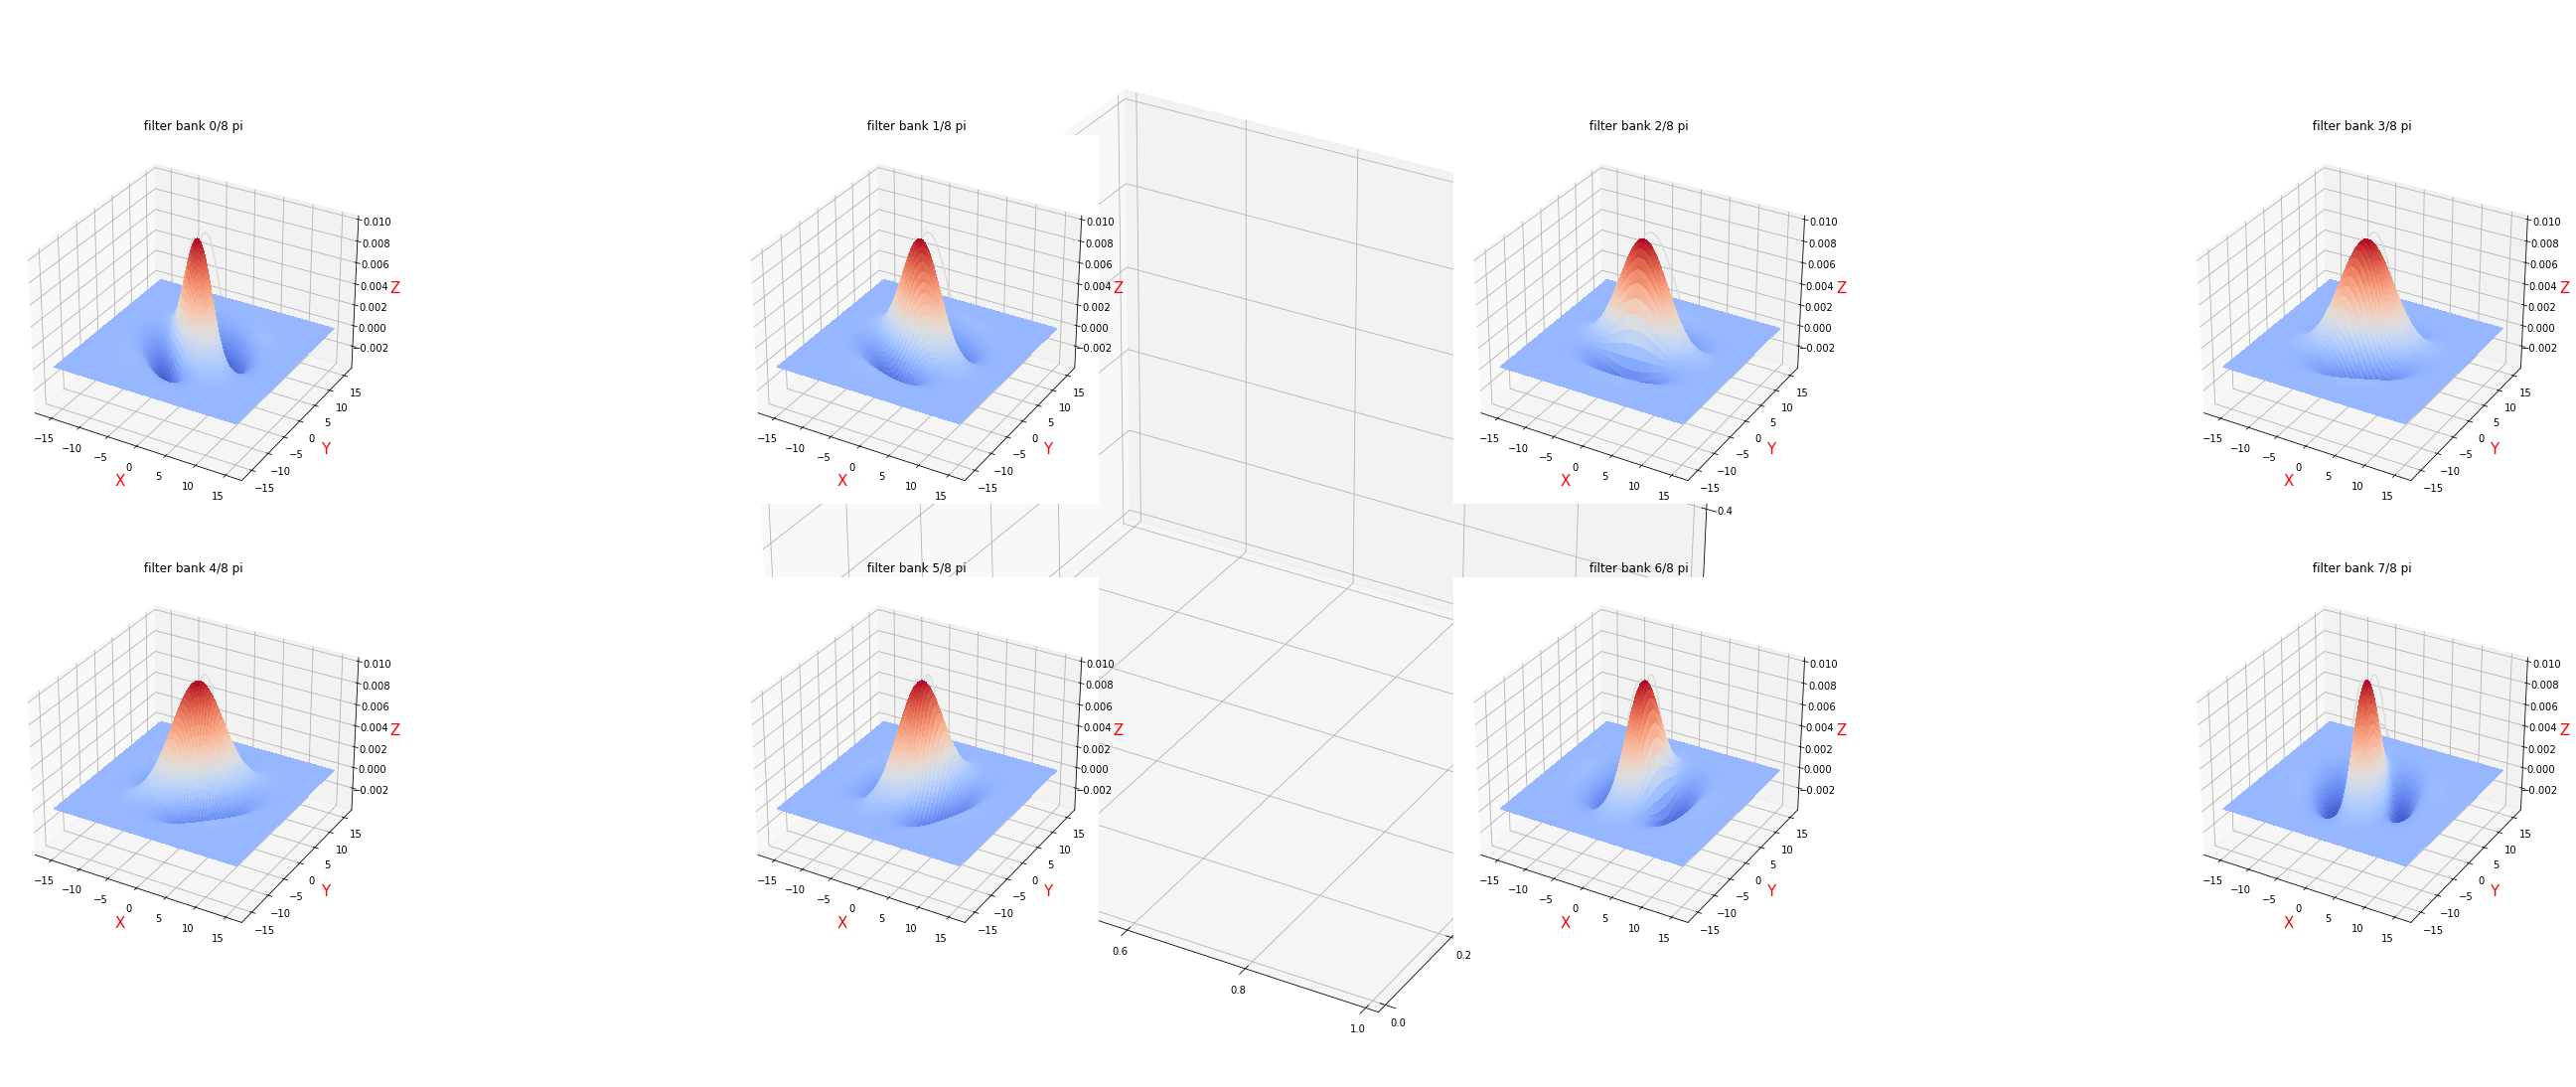

In [105]:
fig = plt.figure(figsize=(50, 15))
ax = Axes3D(fig)
X = np.arange(-np.pi * 5, np.pi * 5, np.pi / 10)
Y = np.arange(-np.pi * 5, np.pi * 5, np.pi / 10)
R = np.arange(0, np.pi, np.pi / 8)
X, Y = np.meshgrid(X, Y)
for i in range(len(filters)):
    Z = spatial_gabor_filter_even(X, Y, spatial_sigma, R[i], f0x, f0y)
    ax = fig.add_subplot(2, math.ceil(len(filters) / 2), i + 1, projection="3d")
    ax.plot_surface(
        X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False
    )
    # ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.25)
    cset = ax.contour(X, Y, Z, zdir="z", offset=-np.pi / 4, cmap=cm.coolwarm)
    cset = ax.contour(X, Y, Z, zdir="x", offset=-np.pi / 4, cmap=cm.coolwarm)
    cset = ax.contour(X, Y, Z, zdir="y", offset=3 * np.pi / 4, cmap=cm.coolwarm)
    # cb = fig.colorbar(p, shrink=0.5)
    ax.set_title(" filter bank " + str(i) + "/8 pi")
    ax.set_zlabel("Z", fontdict={"size": 15, "color": "red"})
    ax.set_ylabel("Y", fontdict={"size": 15, "color": "red"})
    ax.set_xlabel("X", fontdict={"size": 15, "color": "red"})

In [106]:
num_bins_t = space_time_kernel_1.shape[2]
print(num_bins_t)

24


<Figure size 432x288 with 0 Axes>

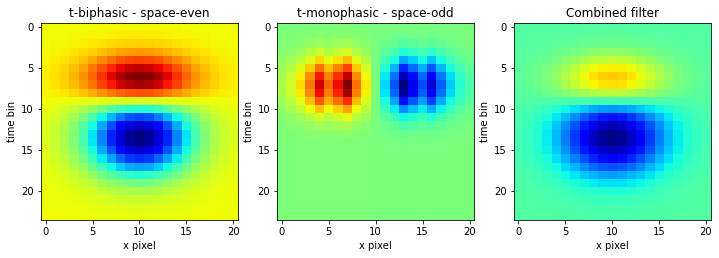

In [128]:
# Plot an x-t slice of each component of the space-time filter
# Fig 3 in the 2014 paper

slice_idx = int(ksize/2)  # index of the central y-slice

max = np.max(space_time_kernel_full)
min = np.min(space_time_kernel_full)
fig = plt.figure()
plt.figure(figsize=(12,12))

plt.subplot(1, 3, 1),
plt.imshow(np.transpose(space_time_kernel_1[:,slice_idx,:]), cmap='jet_r')
#plt.gca().invert_yaxis()
plt.gca().set_aspect( (1. * ksize / num_bins_t) )
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("t-biphasic - space-even")
plt.savefig("filters1.png")
plt.subplot(1, 3, 2),
plt.imshow(np.transpose(space_time_kernel_2[:,slice_idx,:]), cmap='jet_r')
plt.gca().set_aspect( (1. * ksize / num_bins_t) )
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("t-monophasic - space-odd")
plt.savefig("filters2.png")
plt.subplot(1, 3, 3),
plt.imshow(np.transpose(space_time_kernel_full[:,slice_idx,:]), vmin=min, vmax=max, cmap='jet_r')
plt.gca().set_aspect( (1. * ksize / num_bins_t) )
plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("Combined filter")
plt.savefig("filters3.png")


<Figure size 432x288 with 0 Axes>

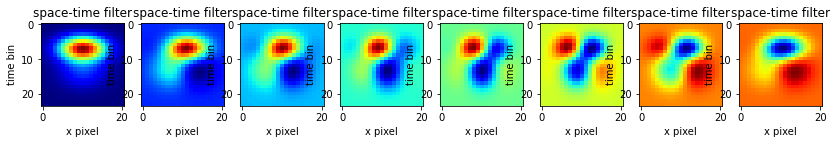

In [136]:
# Show filters
fig = plt.figure()
plt.figure(figsize=(14,14))
num_filters = len(filters)
# print(filters[0][:,5,:])
for i in range(len(filters)):
    plt.subplot(1,num_filters, i+1),
    #plt.imshow(np.transpose(filters[i][:,slice_idx,:]), cmap='jet_r')
    plt.imshow(np.transpose(filters[i][:,5,:]), cmap='jet_r')
    #plt.gca().invert_yaxis()
    plt.gca().set_aspect( (1. * ksize / num_bins_t) )
    plt.xlabel("x pixel"), plt.ylabel("time bin"), plt.title("space-time filter")


In [132]:
plt.savefig("spacetime.png")


<Figure size 432x288 with 0 Axes>

In [109]:
# Compute response of the filter to a given input. See description in LNAI8774 2014
# Bio-inspired optic flow from event-based neuromorphic sensor input, Section 3

In [110]:
# Temporal filters become 0 when t_diff > 0.07
# So we can get a period that uses such
t_diff = 0.07

t_start = event_list[0][0]
t_end = t_start + t_diff

start_ind = 0 # replace with searchsorted left if not 0
end_ind = np.searchsorted(event_list[:,0], t_end, "left")

event_subset = np.empty((end_ind-start_ind, 4), dtype="float64")


for i in np.arange(0, end_ind - start_ind):
    event_subset[i] = event_list[start_ind+i]

print("Time between: {} : {}".format(t_start, t_end))
print(event_subset.shape)

Time between: 0.003811 : 0.073811
(17244, 4)


In [111]:
# First, try the synchronous solution: convert the events to a 3D voxel grid by voting:
# each events fills in some part of the 3D grid, according to a Gaussian weights in space and time

# DAVIS camera pixel resolution
sensor_width = 240
sensor_height = 180

# Select sub-region of the image
band_width = 240
band_height = 180
offset_height = 0
offset_width = 0

# Voting spread of each event
sigma_xy = 1.  # [pixels]
sigma_t =  1.0 # [time bins]

In [112]:
even_filters = list()
odd_filters = list()
filter_amount = 4 # (even+odd)*filter_amount
x_filter = np.arange(-band_width, band_width)  #  can may be optimized (no minus part) by direction / sign change
y_filter = np.arange(-band_height, band_height)
# order is reversed for band_height - width for x, y indexing as in a picture
filter_width, filter_height = np.meshgrid(x_filter, y_filter, indexing="xy")

for i in range(filter_amount):
    angle = np.pi * i / filter_amount
    gabor_even = spatial_gabor_filter_even(filter_width, filter_height, spatial_sigma, angle, f0x, f0y)
    gabor_odd = spatial_gabor_filter_odd(filter_width, filter_height, spatial_sigma, angle, f0x, f0y)

    even_filters.append(gabor_even)
    odd_filters.append(gabor_odd)

In [113]:
# order is reversed for band_height - width for x, y indexing as in a picture
grid_vox = np.zeros((band_height, band_width, filter_amount),dtype=np.float64)

pixels_x = np.arange(0, band_width)
pixels_y = np.arange(0, band_height)
xv, yv = np.meshgrid(pixels_x, pixels_y, indexing="xy")

for ie in range(0,end_ind):
    # x,y,t coordinates in the voxel grid (could be non-integer)
    x = int(event_subset[ie,1])
    y = int(event_subset[ie,2])

    if ((offset_height <= y) and (y < offset_height + band_height)
        and (offset_width <= x) and (x < offset_width + band_width)):
        x -= offset_width
        y -= offset_height
        t = event_subset[ie, 0]

        x_diff = xv - x
        y_diff = yv - y
        t_diff = t_end - t
        
        x_diff_ind = x_diff + band_width
        y_diff_ind = y_diff + band_height
        
        Tmono = temporal_filter(t, mono_mean, mono_sigma)
        Tbi = -1 * scale_bi1 * temporal_filter(t, bi1_mean, bi1_sigma)
        Tbi += scale_bi2 * temporal_filter(t, bi2_mean, bi2_sigma)

        for i in range(filter_amount):
            spatial_even_filter_val = even_filters[i][y_diff_ind, x_diff_ind]
            spatial_odd_filter_val = odd_filters[i][y_diff_ind, x_diff_ind]
            even_filter_val = Tmono * spatial_even_filter_val
            odd_filter_val = Tbi * spatial_odd_filter_val
            filter_val = even_filter_val + odd_filter_val
            grid_vox[:, :, i] += filter_val

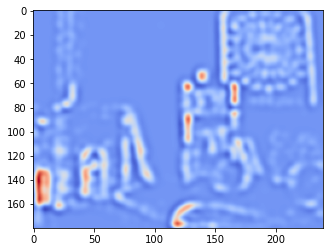

In [133]:
res = np.sum(grid_vox, axis=2)
plt.imshow(res, cmap=cm.coolwarm)
plt.savefig("res.png")
np.save("input_data.npy", grid_vox)
# python scripts/visualize_dsi_volume.py -i input_data.npy

In [115]:
# Visualize results
fig = plt.figure()
plt.figure(figsize=(24, 24))

max = 0
out_xy = []
for i in range(len(outs)):
    out_ = np.sum(np.abs(outs[i]), 2)
    max = np.max([max, np.max(out_)])
    out_xy.append(out_)

for i in range(len(outs)):
    plt.subplot(1, len(outs), i + 1)
    plt.imshow(out_xy[i], vmax=0.8 * max, vmin=0)
    plt.title("Output of filter " + str(i))

NameError: name 'outs' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 1728x1728 with 0 Axes>

In [135]:
u = np.zeros((band_height, band_width), dtype=np.float32)
v = np.zeros((band_height, band_width), dtype=np.float32)
N = 8
with Timer("Aggregate..."):
    for k in range(len(filters)):
        u = u + np.cos(np.pi * 2 * k / N) * grid_vox[:,:,k]
        v = v + (-1) * np.sin(np.pi * 2 * k / N) * grid_vox[:,:,k]
print("u=", u.shape)
print("v=", v.shape)

Aggregate...: 0.00s


IndexError: index 4 is out of bounds for axis 2 with size 4

In [ ]:
fig = plt.figure(figsize=(24, 18))
image = np.zeros((band_height, band_width))
print(image.shape)
plt.imshow(image, cmap="binary")
X, Y = np.meshgrid(np.arange(0, band_width), np.arange(0, band_height))
plt.quiver(X, Y, u, v, color="r")
# for x_ in range(band_width):
#     for y_ in range(band_height):
#         plt.quiver(y_,x_,u[y_,x_],v[y_,x_],color='black',width=0.001,minlength=0.05)
plt.title("Output of velocity ")
plt.show()

In [ ]:
Nx_dft = 2 * ksize
kx = np.arange(-Nx_dft / 2, Nx_dft / 2) * 2.0 / Nx_dft
x = np.arange(0, Nx_dft)  # pixels
f0 = 0.1  # cycles / pix
z = np.sin(2 * np.pi * f0 * x)
plt.plot(x, z)

In [ ]:
# Fourier design
x_ = range(0, Nx_dft)
xv, yv = np.meshgrid(x_, x_)
f0x = 0.057  # cycles / pix
f0y = 0.057  # cycles / pix
z = np.sin(2 * np.pi * (f0x * xv + f0y * yv))
Z = np.fft.fft2(z)
plt.imshow(np.log(1.0 + np.abs(Z)), cmap="gray")
plt.colorbar()

In [ ]:
Nt_dft = 256
F_tmono = np.fft.fft(Tmono, Nt_dft)
F_tbi = np.fft.fft(Tbi, Nt_dft)
kt = ft_nyquist * np.arange(-Nt_dft / 2, Nt_dft / 2) / Nt_dft
plt.plot(kt, np.abs(np.fft.fftshift(F_tmono)))

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(kt, np.abs(np.fft.fftshift(F_tbi)))
freq = np.fft.fftfreq(Nt_dft, d=dt_res)
plt.grid()
# kt = np.fft.fftshift(freq)

In [ ]:
idx = np.argmax(np.abs(np.fft.fftshift(F_tbi)))
print(idx)
print(kt[idx])